In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import utils
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [28]:
path = "data/weather/"
model_path = path + 'models/'
batch_size=64

In [4]:
data = pd.read_csv(path + 'all_data.csv', index_col='DateUTC', parse_dates=True, usecols=['DateUTC','TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2'])
data.index = data.index.tz_localize('UTC').tz_convert('US/Pacific')
data.drop_duplicates(inplace=True)

data = data[data.TemperatureF > 0] # Remove bad temp
data = data[data.PressureIn   > 0] # Remove bad pressure
data = data[data.HourlyPrecipIn >= 0] # Remove bad rainfall

data = data.assign(forward_min = data.rolling('10h', closed='both').TemperatureF.min().shift(-1,'10h').asof(data.index))

data = data.assign(day_of_year = data.index.dayofyear, hour = data.index.hour)
data = data.assign(threshold = 'no')
data.loc[data.forward_min < 32,'threshold'] = '32'
data.loc[data.forward_min < 30,'threshold'] = '30'
data.loc[data.forward_min < 28,'threshold'] = '28'

data = data.merge(pd.get_dummies(data.threshold, prefix='threshold'), left_index=True, right_index=True)

data.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,day_of_year,hour,threshold,threshold_28,threshold_30,threshold_32,threshold_no
DateUTC,,,,,,,,,,,,,,,,,
2016-02-16 11:12:00-08:00,73.8,50.5,29.29,0.0,0.0,44,0.0,0.0,17.48,73.8,47,11,no,0,0,0,1
2016-02-16 11:14:00-08:00,74.5,50.5,29.29,0.0,0.0,43,0.0,0.0,17.48,73.8,47,11,no,0,0,0,1
2016-02-16 11:15:00-08:00,74.5,50.5,29.28,0.0,0.0,43,0.0,0.0,17.48,73.8,47,11,no,0,0,0,1
2016-02-16 11:16:00-08:00,74.5,50.5,29.27,0.0,0.0,43,0.0,0.0,17.53,73.8,47,11,no,0,0,0,1
2016-02-16 11:23:00-08:00,74.5,50.0,29.96,0.0,0.0,42,0.0,0.0,17.43,73.8,47,11,no,0,0,0,1


In [5]:
minutes_in_week = 60*24*7+30
seq_length=32
base = 30
multiple = np.exp(np.log(minutes_in_week/base)/(seq_length-1))
fp_fn_ratio=10
from pandas.tseries.offsets import *
offsets = pd.Series(DateOffset(minutes = base*(multiple**i-1)) for i in range(seq_length-1,-1,-1))
offsets
# wanted_cols = data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2','day_of_year', 'hour']]
# idx=wanted_cols.index[50000]
# %timeit wanted_cols.loc[([wanted_cols.index.asof(i) for i in (idx-offsets)])].values

0     <DateOffset: kwds={'minutes': 10079.99999999998}>
1     <DateOffset: kwds={'minutes': 8349.434435135774}>
2     <DateOffset: kwds={'minutes': 6915.09608830260...
3     <DateOffset: kwds={'minutes': 5726.27866643419...
4     <DateOffset: kwds={'minutes': 4740.95545754265...
5     <DateOffset: kwds={'minutes': 3924.29361517625...
6     <DateOffset: kwds={'minutes': 3247.42275822408...
7     <DateOffset: kwds={'minutes': 2686.41435398226...
8     <DateOffset: kwds={'minutes': 2221.43580394224...
9     <DateOffset: kwds={'minutes': 1836.04932779933...
10    <DateOffset: kwds={'minutes': 1516.630860041915}>
11    <DateOffset: kwds={'minutes': 1251.88841613045...
12    <DateOffset: kwds={'minutes': 1032.46290169388...
13    <DateOffset: kwds={'minutes': 850.5972526714213}>
14    <DateOffset: kwds={'minutes': 699.862209942718...
15     <DateOffset: kwds={'minutes': 574.929034114572}>
16    <DateOffset: kwds={'minutes': 471.381125546298...
17    <DateOffset: kwds={'minutes': 385.55789006

In [6]:
wanted_cols = data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2','day_of_year', 'hour']]

# TODO: This below takes 18 minutes to run on 124,028 data points.  Surely that could be faster??!?
# all_x = np.nan_to_num([wanted_cols.loc[([wanted_cols.index.asof(i) for i in (idx-offsets)])].values for idx in zip(wanted_cols.index)])
# all_y = data.threshold_32.values.reshape(-1,1)
# save_array(path+'all_x', all_x)
# save_array(path+'all_y', all_y)

all_x = load_array(path+'all_x')
all_y = load_array(path+'all_y')

all_x.shape, all_y.shape

((105241, 32, 11), (105241, 1))

In [7]:
train_idx = np.where(data.day_of_year%10!=0)
val_idx = np.where(data.day_of_year%10==0)

train_x, train_y = all_x[train_idx], all_y[train_idx]
val_x, val_y = all_x[val_idx], all_y[val_idx]

train_data = data.iloc[train_idx]
validation_data = data.iloc[val_idx]

In [8]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, train_y.sum(), val_y.sum()

((94899, 32, 11), (94899, 1), (10342, 32, 11), (10342, 1), 2227, 153)

In [34]:
model = Sequential([
    BatchNormalization(input_shape=(seq_length, train_x.shape[2])),
    Dropout(0.25),
    
    Conv1D(16, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(16, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

    Conv1D(16, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(16, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

    Conv1D(16, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(16, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

    Conv1D(16, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(16, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

#     Conv1D(4, 3, padding='same', activation='relu'),
#     MaxPooling1D(),
#     BatchNormalization(),

#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(4),
    
    Flatten(),

    Dense(128),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    
    Dropout(0.75),
    Dense(train_y.shape[1], activation='sigmoid'),
])
model.compile(Nadam(), 'binary_crossentropy', ['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_80 (Batc (None, 32, 11)            44        
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 11)            0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 32, 16)            544       
_________________________________________________________________
p_re_lu_72 (PReLU)           (None, 32, 16)            512       
_________________________________________________________________
batch_normalization_81 (Batc (None, 32, 16)            64        
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 32, 16)            784       
_________________________________________________________________
p_re_lu_73 (PReLU)           (None, 32, 16)            512       
__________

Train on 94899 samples, validate on 10342 samples
Epoch 1/20
94899/94899 [==============================] - 42s - loss: 0.3648 - binary_accuracy: 0.8986 - val_loss: 0.1297 - val_binary_accuracy: 0.9292
Epoch 2/20
94899/94899 [==============================] - 39s - loss: 0.1883 - binary_accuracy: 0.9491 - val_loss: 0.0647 - val_binary_accuracy: 0.9765
Epoch 3/20
94899/94899 [==============================] - 39s - loss: 0.1591 - binary_accuracy: 0.9602 - val_loss: 0.0464 - val_binary_accuracy: 0.9811
Epoch 4/20
94784/94899 [============================>.] - ETA: 0s - loss: 0.1299 - binary_accuracy: 0.9683

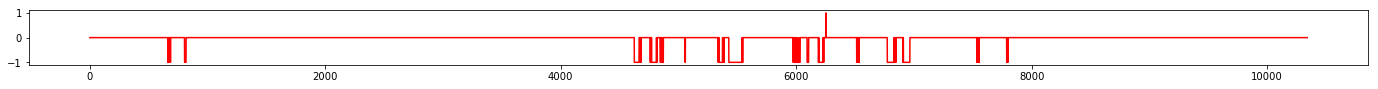

94899/94899 [==============================] - 41s - loss: 0.1300 - binary_accuracy: 0.9683 - val_loss: 0.1333 - val_binary_accuracy: 0.9470
Epoch 5/20
94899/94899 [==============================] - 39s - loss: 0.1267 - binary_accuracy: 0.9697 - val_loss: 0.0820 - val_binary_accuracy: 0.9653
Epoch 6/20
94784/94899 [============================>.] - ETA: 0s - loss: 0.1058 - binary_accuracy: 0.9759
Epoch 00005: reducing learning rate to 0.00020000000949949026.
94899/94899 [==============================] - 40s - loss: 0.1057 - binary_accuracy: 0.9758 - val_loss: 0.0980 - val_binary_accuracy: 0.9690
Epoch 7/20
94899/94899 [==============================] - 39s - loss: 0.0800 - binary_accuracy: 0.9818 - val_loss: 0.0754 - val_binary_accuracy: 0.9751
Epoch 8/20
94848/94899 [============================>.] - ETA: 0s - loss: 0.0673 - binary_accuracy: 0.9841
Epoch 00007: reducing learning rate to 2.0000000949949027e-05.


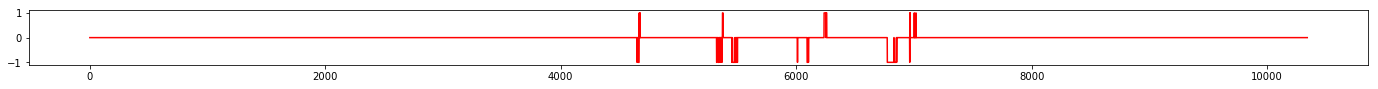

94899/94899 [==============================] - 40s - loss: 0.0674 - binary_accuracy: 0.9841 - val_loss: 0.0552 - val_binary_accuracy: 0.9824
Epoch 9/20
94899/94899 [==============================] - 39s - loss: 0.0654 - binary_accuracy: 0.9853 - val_loss: 0.0631 - val_binary_accuracy: 0.9779
Epoch 10/20
94784/94899 [============================>.] - ETA: 0s - loss: 0.0643 - binary_accuracy: 0.9853
Epoch 00009: reducing learning rate to 2.0000001313746906e-06.
94899/94899 [==============================] - 39s - loss: 0.0643 - binary_accuracy: 0.9853 - val_loss: 0.0644 - val_binary_accuracy: 0.9788
Epoch 11/20
94899/94899 [==============================] - 39s - loss: 0.0661 - binary_accuracy: 0.9854 - val_loss: 0.0630 - val_binary_accuracy: 0.9777
Epoch 12/20
94848/94899 [============================>.] - ETA: 0s - loss: 0.0605 - binary_accuracy: 0.9855
Epoch 00011: reducing learning rate to 2.000000222324161e-07.


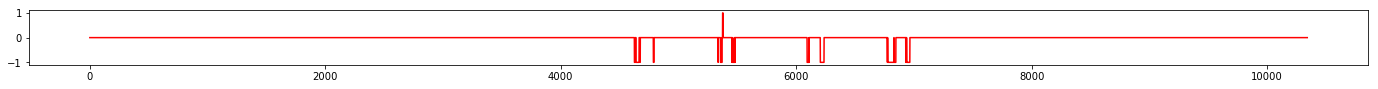

94899/94899 [==============================] - 40s - loss: 0.0605 - binary_accuracy: 0.9855 - val_loss: 0.0624 - val_binary_accuracy: 0.9779
Epoch 13/20
94899/94899 [==============================] - 39s - loss: 0.0626 - binary_accuracy: 0.9857 - val_loss: 0.0551 - val_binary_accuracy: 0.9821
Epoch 14/20
94784/94899 [============================>.] - ETA: 0s - loss: 0.0623 - binary_accuracy: 0.9856
Epoch 00013: reducing learning rate to 2.000000165480742e-08.
94899/94899 [==============================] - 39s - loss: 0.0623 - binary_accuracy: 0.9856 - val_loss: 0.0654 - val_binary_accuracy: 0.9786
Epoch 15/20
94899/94899 [==============================] - 39s - loss: 0.0619 - binary_accuracy: 0.9860 - val_loss: 0.0535 - val_binary_accuracy: 0.9828
Epoch 16/20
94848/94899 [============================>.] - ETA: 0s - loss: 0.0633 - binary_accuracy: 0.9857
Epoch 00015: reducing learning rate to 2.000000165480742e-09.


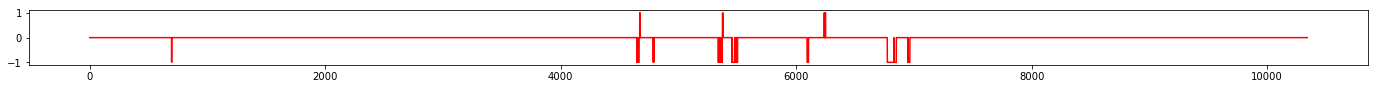

94899/94899 [==============================] - 40s - loss: 0.0633 - binary_accuracy: 0.9857 - val_loss: 0.0541 - val_binary_accuracy: 0.9825
Epoch 17/20
94899/94899 [==============================] - 39s - loss: 0.0624 - binary_accuracy: 0.9855 - val_loss: 0.0614 - val_binary_accuracy: 0.9784
Epoch 18/20
94784/94899 [============================>.] - ETA: 0s - loss: 0.0589 - binary_accuracy: 0.9857
Epoch 00017: reducing learning rate to 2.000000165480742e-10.
94899/94899 [==============================] - 39s - loss: 0.0589 - binary_accuracy: 0.9858 - val_loss: 0.0582 - val_binary_accuracy: 0.9799
Epoch 19/20
94899/94899 [==============================] - 39s - loss: 0.0610 - binary_accuracy: 0.9858 - val_loss: 0.0639 - val_binary_accuracy: 0.9773
Epoch 20/20
94848/94899 [============================>.] - ETA: 0s - loss: 0.0631 - binary_accuracy: 0.9853
Epoch 00019: reducing learning rate to 2.000000165480742e-11.


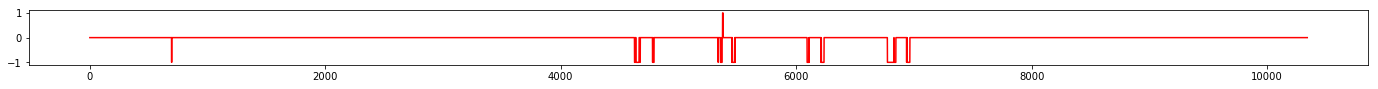

94899/94899 [==============================] - 40s - loss: 0.0631 - binary_accuracy: 0.9854 - val_loss: 0.0608 - val_binary_accuracy: 0.9783


In [35]:
class GraphCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch%4==3:
            plt.figure(figsize=(24,1))
    #         plt.plot(validation_data.TemperatureF.as_matrix(), 'g')
    #         plt.plot(validation_data.forward_min.as_matrix(), 'c')
            plt.plot((val_y-np.round(model.predict(val_x, batch_size=batch_size))), 'r')
    #         plt.axhline(32)
            plt.show()

reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)
graph_cb = GraphCallback()

model.fit(train_x, train_y,
          epochs=20,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          class_weight={0:1, 1:fp_fn_ratio, 2:fp_fn_ratio**2},
          callbacks=[reduce_lr, graph_cb])

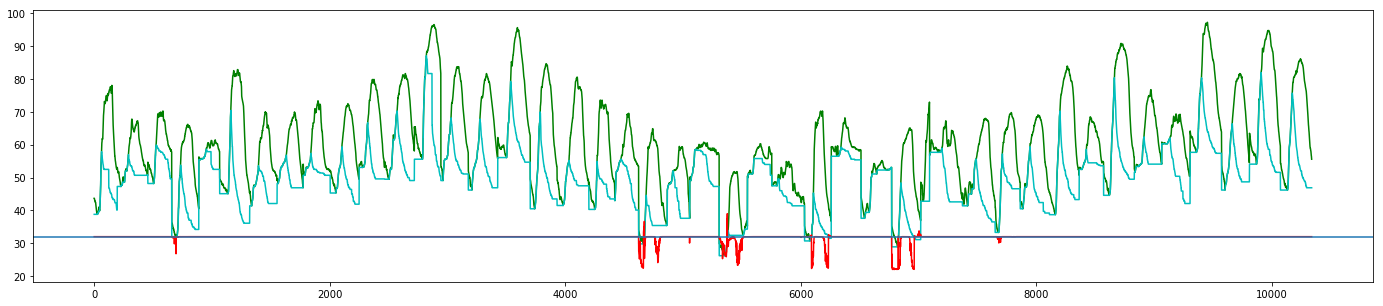

In [55]:
plt.figure(figsize=(24,5))
plt.plot(validation_data.TemperatureF.as_matrix(), 'g')
plt.plot(validation_data.forward_min.as_matrix(), 'c')
plt.plot((val_y-model.predict(val_x, batch_size=batch_size))*10+32, 'r')
plt.axhline(32)
plt.show()

In [47]:
prediction_data = validation_data.assign(prediction = np.round(model.predict(val_x, batch_size=batch_size)).astype(int))
prediction_data.index = prediction_data.index.tz_convert('UTC')
prediction_data = prediction_data.merge(pd.get_dummies(prediction_data.prediction, prefix='prediction'), left_index=True, right_index=True)
prediction_data = prediction_data.assign(fn = prediction_data.threshold_32*prediction_data.prediction_0)
prediction_data = prediction_data.assign(fp = prediction_data.threshold_no*prediction_data.prediction_1)

In [45]:
resample = '2H'
extract = prediction_data.TemperatureF.resample(resample).min().to_frame().merge(prediction_data.forward_min.resample(resample).min().to_frame(), left_index=True, right_index=True).merge(prediction_data.threshold_32.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.prediction_1.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.fn.resample(resample).prod().to_frame(), left_index=True, right_index=True).merge(prediction_data.fp.resample(resample).prod().to_frame(), left_index=True, right_index=True)
extract.fp = extract.fp * 32
extract.fn = extract.fn * 32
extract.fp[extract.fp==0] = float('nan')
extract.fn[extract.fn==0] = float('nan')
extract.fn.count(), extract.fp.count()

(0, 0)